### Computational Environment
This notebook was executed on the following hardware:
* **Machine:** MacBook Air (M2, 2022)
* **Chip:** Apple M2 (8-core CPU, 8/10-core GPU)
* **Accelerator:** Metal Performance Shaders (MPS) via TensorFlow-Metal
* **Optimization:** Uses `tf.keras.optimizers.legacy.Adam` to enable GPU acceleration on macOS.
---

## Import Libraries

In [1]:
# Standard Library
import os
import sys
import time
import random
import gc
import itertools
from pathlib import Path

# Numerical & Data Handling
import numpy as np
import pandas as pd

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# Image Processing
from PIL import Image

# Progress Bar
from tqdm import tqdm

# Sklearn Utilities & Metrics
from sklearn.utils import class_weight
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_curve,
    auc
)

## Reproducibility Setup

In [2]:
# Set Python environment variables
os.environ['PYTHONHASHSEED'] = '0'
# TF to use deterministic ops where possible
os.environ['TF_DETERMINISTIC_OPS'] = '1'

# Set Random Seeds
seed_value = 42
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

print(f"Global Random Seed set to: {seed_value}")

Global Random Seed set to: 42


It is noted that on Apple M2, minor floating-point jitter is unavoidable.

## TQDM bar for Training and Tuning

In [3]:
class TqdmCallback(keras.callbacks.Callback):
    def __init__(self, pbar):
        super().__init__()
        self.pbar = pbar

    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        self.pbar.update(1)
        
        # Calculate gap
        train_acc = logs.get('accuracy', 0)
        val_acc = logs.get('val_accuracy', 0)
        gap = train_acc - val_acc
        
        self.pbar.set_postfix({
            "loss": f"{logs.get('loss', 0):.3f}",
            "v_auc": f"{logs.get('val_auc', 0):.3f}",
            "gap": f"{gap:.3f}"
        })
        # Prevent the "multi-line" ghosting
        self.pbar.refresh()

# 1. Defining the problem and assembling a dataset
**Objective:**
To build a binary classification model capable of detecting breast cancer (Malignant vs. Benign) from mammography patches.

**Problem Type:**
Binary Classification (Imbalanced).

**Dataset:**
The [CBIS-DDSM](https://wiki.cancerimagingarchive.net/display/Public/CBIS-DDSM) (Curated Breast Imaging Subset of DDSM) dataset.
- **Input:** 224x224 grayscale images of mammogram masses.
- **Output:** A probability score (0-1) indicating malignancy.
- **Preprocessing:** Images were preprocessed externally to square crops preserving aspect ratio, ensuring no tumor distortion.

In [4]:
# Load the config file created by preprocess.py script
config_path = Path("/Users/ay/Downloads/Github/FYP/processed_data_v3_square/config.json")
print(f"Project Configuration found at: {config_path}")

Project Configuration found at: /Users/ay/Downloads/Github/FYP/processed_data_v3_square/config.json


# 2. Choosing a measure of success

To ensure clinical relevance, we evaluate the model using a multi-dimensional approach rather than a single metric.

**1. Primary Metric: AUC-ROC**
   - Serves as the global performance benchmark, robust to class imbalance.

**2. Clinical Safety Metrics:**
   - **Sensitivity (Recall):** Critical for minimizing False Negatives (missing cancer).
   - **Specificity:** Critical for minimizing False Positives (reducing unnecessary biopsies).

**3. Precision & F1-Score:**
   - Monitors the "False Alarm" rate and provides a balanced view of performance on the minority (Malignant) class.

**4. Confusion Matrix:**
   - We will inspect raw TP, TN, FP, FN counts to understand specific failure modes.

# 3. Deciding on an evaluation protocol
To ensure the model generalizes well to new patients, we utilize a **Hold-Out Validation Set**.

**Protocol Details:**
- **Split Ratio:** 80% Training / 20% Validation.
- **Grouping:** The split was performed using `GroupShuffleSplit` on `patient_id`.
    - *Constraint:* All images from the same patient (e.g., CC and MLO views) are kept in the same set to prevent **Data Leakage**.
- **Test Set:** A separate, official test set provided by CBIS-DDSM is held back completely until the final evaluation.

# 4. Preparing the Data
## 4.1 Configuration & Imports

In [4]:
# Configuration (v3_square folder)
BASE_DIR = Path("/Users/ay/Downloads/Github/FYP/processed_data_v3_square")
GREY_DIR = BASE_DIR / "processed_greyscale"
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 32
RANDOM_SEED = 42

print(f"Configuration set at \nBase Dir: {BASE_DIR}")

Configuration set at 
Base Dir: /Users/ay/Downloads/Github/FYP/processed_data_v3_square


## 4.2 Visual Audit (Verification)

Visual check of preprocessed data


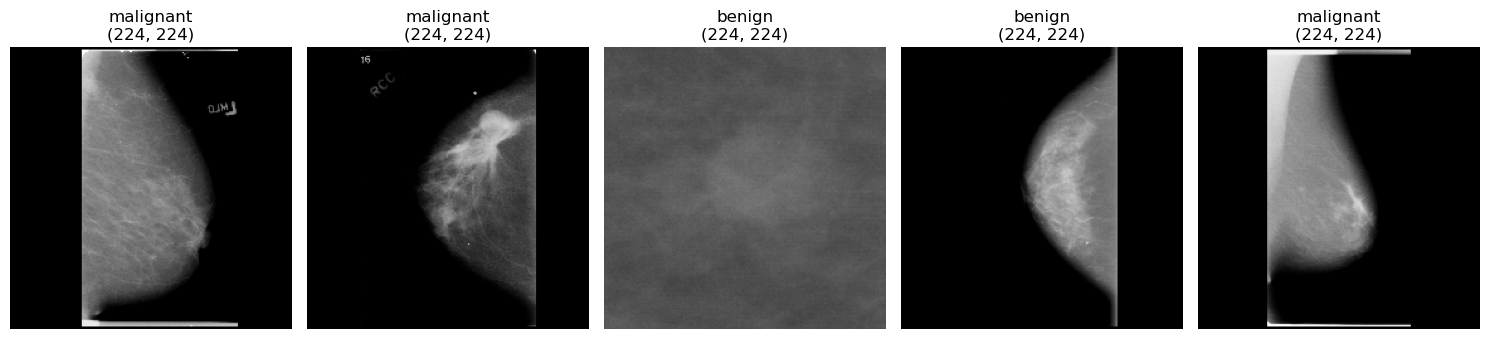

In [5]:
# Checks if images are square, padded correctly, and readable
def verify_data_integrity(n=3):
    train_dir = GREY_DIR / "train"
    # Get list of all png files
    all_files = list(train_dir.rglob("*.png"))
    
    if not all_files:
        print("No images found.")
        return

    # Pick random samples to verify
    samples = random.sample(all_files, n)
    
    plt.figure(figsize=(15, 5))
    for i, img_path in enumerate(samples):
        try:
            img = Image.open(img_path)
            img_arr = np.array(img)
            
            plt.subplot(1, n, i+1)
            plt.imshow(img_arr, cmap='gray', vmin=0, vmax=255)
            # Title shows class (benign/malignant) and dimensions
            plt.title(f"{img_path.parent.name}\n{img_arr.shape}")
            plt.axis('off')
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            
    plt.tight_layout()
    plt.show()

print("Visual check of preprocessed data")
verify_data_integrity(n=5)

## 4.3 Data Generators (Loading)

In [6]:
# Create ImageDataGenerator (Rescaling augmentation only)
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

print("Loading Training Set:")
train_gen = train_datagen.flow_from_directory(
    GREY_DIR / "train",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED
)

print("\nLoading Validation Set:")
val_gen = test_datagen.flow_from_directory(
    GREY_DIR / "val",
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    color_mode='grayscale',
    seed=RANDOM_SEED,
    # Do not shuffle Val set
    shuffle=False
)

# Quick check of the class indices
print(f"\nClass Indices: {train_gen.class_indices}")

# Get raw counts
train_counts = np.bincount(train_gen.classes)
val_counts = np.bincount(val_gen.classes)

print(f"Train class counts: {train_counts}")
print(f"Val class counts:   {val_counts}")

Loading Training Set:
Found 1061 images belonging to 2 classes.

Loading Validation Set:
Found 257 images belonging to 2 classes.

Class Indices: {'benign': 0, 'malignant': 1}
Train class counts: [568 493]
Val class counts:   [113 144]


## 4.4 Verify no Data Leakage

In [23]:
# Get all filenames from the folders directly
def get_filenames(subset_dir):
    files = []
    for root, dirs, filenames in os.walk(subset_dir):
        for f in filenames:
            # Only count images, ignore hidden files like .DS_Store
            if f.lower().endswith(('.png', '.jpg', '.jpeg')):
                files.append(f)
    return set(files)

# Gather filenames
train_files = get_filenames(GREY_DIR / "train")
val_files = get_filenames(GREY_DIR / "val")
test_files = get_filenames(GREY_DIR / "test")

# Check for overlaps
train_test_overlap = train_files.intersection(test_files)
val_test_overlap = val_files.intersection(test_files)

if not train_test_overlap and not val_test_overlap:
    print("Test set is separate from Train/Val.")
else:
    if train_test_overlap: print(f"Leakage: {len(train_test_overlap)} files in Train & Test")
    if val_test_overlap: print(f"Leakage: {len(val_test_overlap)} files in Val & Test")

Test set is separate from Train/Val.


## 4.5 Define Class Weights

In [8]:
# Calculate class weights dynamically
weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_gen.classes),
    y=train_gen.classes
)
class_weights_dict = dict(enumerate(weights))

print(f"Calculated Class Weights: {class_weights_dict}")

Calculated Class Weights: {0: 0.9339788732394366, 1: 1.0760649087221095}


## 4.6 Helper Functions for Evaluation and Visualisation

In [17]:
# Plot accuracy and loss curves for training and validation
def plot_training_history(history, title_prefix="Model"):
    # Check if passing a Keras history object or a dictionary/dataframe
    hist = history.history if hasattr(history, 'history') else history
    
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Train Acc')
    plt.plot(epochs_range, val_acc, label='Val Acc')
    plt.title(f'{title_prefix} Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.6)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Train Loss')
    plt.plot(epochs_range, val_loss, label='Val Loss')
    plt.title(f'{title_prefix} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

# Generate a Baseline Table, classification report and a confusion matrix heatmap
def eval_model_perf(model, generator, step_name="Step X", baseline_acc=0.5353):
    # Reset generator to ensure order matches labels
    generator.reset()
    
    # Get metrics from model.evaluate
    results = model.evaluate(generator, verbose=0)
    metrics_dict = dict(zip(model.metrics_names, results))
    
    # Generate predictions for Specificity and Confusion Matrix (reset generator)
    generator.reset()
    y_pred_raw = model.predict(generator, verbose=0)
    y_pred = (y_pred_raw > 0.5).astype(int).flatten()
    y_true = generator.classes
    
    # Calculate Confusion Matrix & Clinical Metrics
    cm = confusion_matrix(y_true, y_pred)
    # Handle cases where the model might predict only one class
    if cm.size == 4:
        tn, fp, fn, tp = cm.ravel()
    else:
        # Fallback for single-class predictions
        tn = np.sum((y_true == 0) & (y_pred == 0))
        fp = np.sum((y_true == 0) & (y_pred == 1))
        fn = np.sum((y_true == 1) & (y_pred == 0))
        tp = np.sum((y_true == 1) & (y_pred == 1))
    
    # Manual calculations to ensure transparency
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    sensitivity = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / len(y_true)
    
    # Print Statistical Power Table
    print(f"\n{step_name} Evaluation: Statistical Power Check")
    print("-" * 60)
    print(f"{'Metric':<20} | {'Baseline':<10} | {'Model (Val)':<10}")
    print("-" * 60)
    print(f"{'Accuracy':<20} | {baseline_acc:<10.4f} | {accuracy:.4f}")
    
    # Find AUC in the metrics_dict (handle case-sensitive names)
    auc_val = metrics_dict.get('auc', metrics_dict.get('AUC', 0.5000))
    print(f"{'AUC-ROC':<20} | {'0.5000':<10} | {auc_val:.4f}")
    print(f"{'Sensitivity':<20} | {'0.0000':<10} | {sensitivity:.4f}")
    print(f"{'Specificity':<20} | {'1.0000':<10} | {specificity:.4f}")
    print("-" * 60)
    
    # Classification Report
    print("\nDetailed Classification Report:")
    # Map indices back to names for the report
    target_names = list(generator.class_indices.keys())
    target_names = [name.capitalize() for name in target_names]
    print(classification_report(y_true, y_pred, target_names=target_names))
    
    # Heatmap Visualisation
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=[f'Pred {target_names[0]}', f'Pred {target_names[1]}'],
                yticklabels=[f'True {target_names[0]}', f'True {target_names[1]}'])
    plt.title(f'Confusion Matrix ({step_name})')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Return dictionary
    return {
        "Val Acc": accuracy,
        "Val AUC": auc_val,
        "Sensitivity": sensitivity,
        "Specificity": specificity
    }

# Step 5: Developing a model that does better than a baseline
## 5.1. Majority Baseline

In [10]:
# Distribution Stats
n_benign = (train_gen.classes == 0).sum()
n_malignant = (train_gen.classes == 1).sum()
total = len(train_gen.classes)

# Determine majority class and its baseline accuracy
if n_benign >= n_malignant:
    majority_class = "Benign (0)"
    majority_baseline_acc = n_benign / total
    # Cannot catch any malignant cases
    baseline_sensitivity = 0.0
    # Correctly identifies all benign cases
    baseline_specificity = 1.0
else:
    majority_class = "Malignant (1)"
    majority_baseline_acc = n_malignant / total
    baseline_sensitivity = 1.0
    baseline_specificity = 0.0

print("Majority Baseline: Clinical Metric Floor")
print("-" * 40)
print(f"Majority Class:      {majority_class}")
print(f"Baseline Accuracy:    {majority_baseline_acc:.4f}")
print(f"Baseline AUC:         0.5000")
print("-" * 40)
print("Baseline Performance (Predicting Majority Only):")
print(f"  Sensitivity:        {baseline_sensitivity:.4f}")
print(f"  Specificity:        {baseline_specificity:.4f}")

Majority Baseline: Clinical Metric Floor
----------------------------------------
Majority Class:      Benign (0)
Baseline Accuracy:    0.5353
Baseline AUC:         0.5000
----------------------------------------
Baseline Performance (Predicting Majority Only):
  Sensitivity:        0.0000
  Specificity:        1.0000


### 5.1.1 Save the Results

In [20]:
# Create a dictionary for the baseline stats
baseline_summary = {
    "Majority Baseline": {
        "Val Acc": majority_baseline_acc,
        "Val AUC": 0.5000,
        "Sensitivity": baseline_sensitivity,
        "Specificity": baseline_specificity,
        "Model Type": "Heuristic/Naive"
    }
}

# Convert to DataFrame and save
pd.DataFrame(baseline_summary).T.to_csv('baseline_summary.csv')

The Small CNN's AUC must be more than 0.5000 and demonstrate that the Sensitivity > 0.0000 to prove learning.

## 5.2. Small CNN Architecture

In [11]:
def build_small_cnn():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: Flattened spatial features
    x = layers.Flatten()(x)
    
    # Dense layer for feature interpretation
    x = layers.Dense(256, activation="relu")(x)
    
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy", 
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='sensitivity')
        ]
    )
    return model

model_step5 = build_small_cnn()
model_step5.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856 

### 5.2.1 Train the Model

In [12]:
# Training Callbacks
callbacks_step5 = [
    keras.callbacks.EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=0
    )
]

# Training Execution
epochs = 30
start_time = time.time()

# Tqdm bar
pbar = tqdm(total=epochs, desc="Small CNN Training Progress", unit="epoch", leave=True)

history_step5 = model_step5.fit(
    train_gen,
    epochs=epochs,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks_step5 + [TqdmCallback(pbar)],
    verbose=0
)

# Clean up the bar
pbar.close()

end_time = time.time()
total_minutes = (end_time - start_time) / 60
print(f"\nTotal time taken: {total_minutes:.2f} minutes")

Small CNN Training Progress:  20%|▏| 6/30 [04:28<17:54, 44.78s/epoch, loss=0.618


Total time taken: 4.48 minutes


### 5.2.2 Display Plots and Metrics (Save the Results)

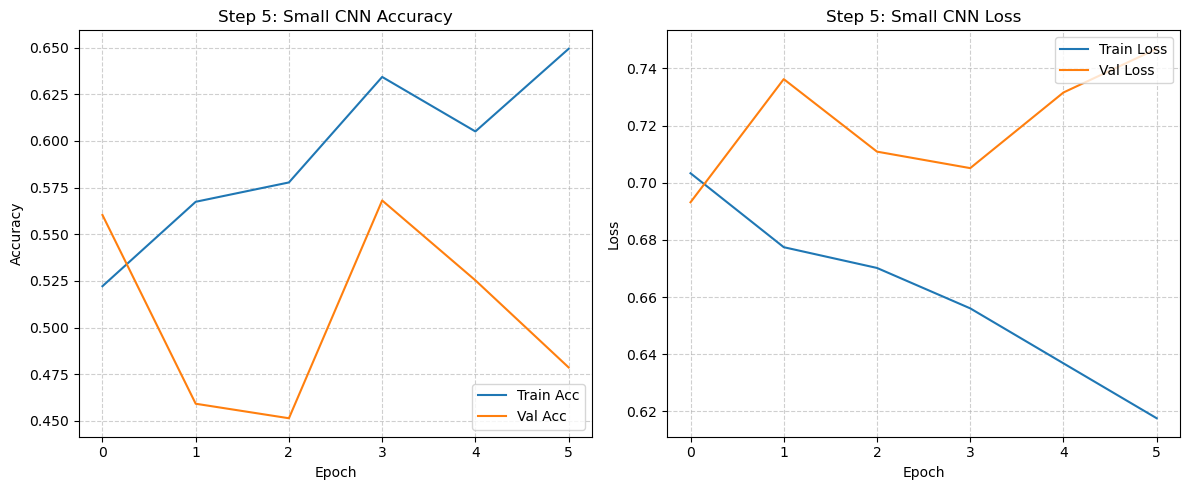

Majority Baseline Accuracy: 0.5353

Step 5 Baseline Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5603
AUC-ROC              | 0.5000     | 0.5116
Sensitivity          | 0.0000     | 0.8542
Specificity          | 1.0000     | 0.1858
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.50      0.19      0.27       113
   Malignant       0.57      0.85      0.69       144

    accuracy                           0.56       257
   macro avg       0.54      0.52      0.48       257
weighted avg       0.54      0.56      0.50       257



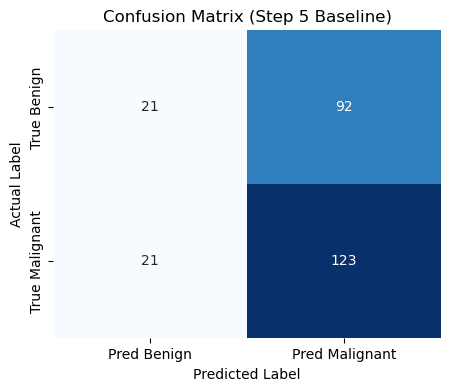

In [22]:
# Save the model
model_step5.save("step5_small_cnn_model.keras")

# Save the Training History
history_df_step5 = pd.DataFrame(history_step5.history)
history_df_step5.to_csv('step5_history.csv', index=False)

# Visualise Training Results
plot_training_history(history_step5, title_prefix="Step 5: Small CNN")

# Evaluate Performance
print(f"Majority Baseline Accuracy: {majority_baseline_acc:.4f}")

# Capture evaluation stats
stats_step5 = eval_model_perf(
    model_step5, 
    val_gen, 
    step_name="Step 5 Baseline", 
    baseline_acc=majority_baseline_acc
)

step5_summary = {
    "Step 5 Small CNN": {
        "Train Acc": history_step5.history['accuracy'][-1],
        "Val Acc": stats_step5["Val Acc"],
        "Val AUC": stats_step5["Val AUC"],
        "Sensitivity": stats_step5["Sensitivity"],
        "Specificity": stats_step5["Specificity"],
        "Gap": abs(history_step5.history['accuracy'][-1] - stats_step5["Val Acc"])
    }
}

pd.DataFrame(step5_summary).T.to_csv('step5_summary.csv')

The Small CNN exceeded the baseline accuracy (0.5603 versus 0.5353); however, the AUC-ROC of 0.5116 indicates performance only marginally better than random classification. Notably, Sensitivity reached 0.8542, substantially surpassing the Majority Baseline of 0.0000. This proves that the model can learn and validates proceeding to the next step.

# 6. Scaling up: developing a model that overfits

## 6.1 Build Overfit Model
The purpose of this model is to be intentionally over-parameterised to verify that the dataset is learnable and that the network possesses sufficient representational capacity.

In [14]:
def build_overfit_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: Flatten + High Capacity Dense
    x = layers.Flatten()(x) 
    x = layers.Dense(512, activation="relu")(x)
    x = layers.Dense(256, activation="relu")(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy", 
            keras.metrics.AUC(name='auc'),
            keras.metrics.Recall(name='sensitivity')
        ]
    )
    return model

model_step6 = build_overfit_model()
model_step6.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 128)       7385

### 6.1.1 Train the Model

In [15]:
# Configuration
epochs_step6 = 100

# Callbacks (Only checkpoint and no early stopping)
callbacks_step6 = [
    # Save model with highest training accuracy
    keras.callbacks.ModelCheckpoint(
        "step6_overfit_model.keras",
        # Monitor training accuracy
        monitor="accuracy",
        save_best_only=True,
        mode="max",
        verbose=0
    )
]

pbar = tqdm(total=epochs_step6, desc="Step 6 Overfit Progress")

start_time = time.time()

# Train for full 100 epochs
history_step6 = model_step6.fit(
    train_gen,
    epochs=epochs_step6,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks_step6 + [TqdmCallback(pbar)],
    verbose=0
)
pbar.close()

total_time = time.time() - start_time
print(f"\nTotal time taken: {total_time/60:.2f} minutes")

Step 6 Overfit Progress: 100%|█| 100/100 [1:57:09<00:00, 70.29s/it, loss=0.011, 


Total time taken: 117.16 minutes


### 6.1.2 Display Plots and Metrics

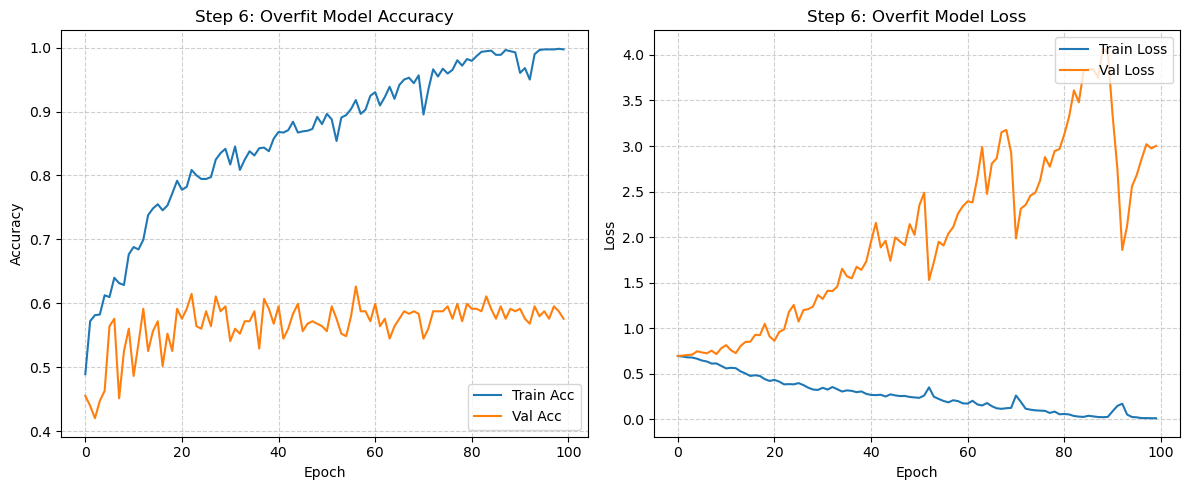


Step 6 Overfit Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5875
AUC-ROC              | 0.5000     | 0.6037
Sensitivity          | 0.0000     | 0.5694
Specificity          | 1.0000     | 0.6106
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.53      0.61      0.57       113
   Malignant       0.65      0.57      0.61       144

    accuracy                           0.59       257
   macro avg       0.59      0.59      0.59       257
weighted avg       0.60      0.59      0.59       257



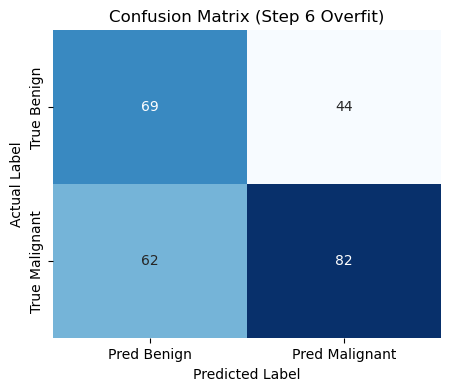

In [18]:
# Visualise the History
plot_training_history(history_step6, title_prefix="Step 6: Overfit Model")

# Load Peak Weights for the Summary Table
model_step6.load_weights("step6_overfit_model.keras")

# Evaluate and Automate the Summary
stats = eval_model_perf(model_step6, val_gen, step_name="Step 6 Overfit", baseline_acc=majority_baseline_acc)

# Use max() for Train Acc to match the loaded peak weights
peak_train_acc = max(history_step6.history['accuracy'])

step6_summary = {
    "Step 6 Overfit": {
        "Train Acc": peak_train_acc,
        "Val Acc": stats["Val Acc"],
        "Val AUC": stats["Val AUC"],
        "Sensitivity": stats["Sensitivity"],
        "Specificity": stats["Specificity"],
        "Gap": abs(peak_train_acc - stats["Val Acc"])
    }
}

The high-capacity Flatten-based CNN successfully memorised the training data, achieving near-perfect training accuracy. However, validation loss diverged significantly, confirming severe overfitting. Although validation AUC improved to 0.6037 compared to previous baselines, the large generalisation gap indicates that architectural and regularisation strategies are required to stabilise performance.

## 6.1.3 Save the Results

In [19]:
# Save everything
pd.DataFrame(step6_summary).T.to_csv('step6_overfit_summary.csv')

# Save history
history_df = pd.DataFrame(history_step6.history)
history_df.to_csv('step6_history.csv', index=False)

# Save the Model (Architecture + Peak Weights)
model_step6.save("step6_overfit_model_final.keras")

# 7 Regularisation and Hyperparameter Tuning¶
The objective of this section is to reduce the generalisation gap observed in Step 6 through architectural refinement, explicit regularisation techniques, and systematic hyperparameter optimisation.

## 7.1 Capacity Control via Architectural Simplification (GAP)
The Flatten-based classification head introduces a substantial number of trainable parameters, increasing the model’s effective capacity and susceptibility to overfitting. To mitigate excessive parameterisation and encourage spatial summarisation of feature maps, the classification head was replaced with Global Average Pooling (GAP). 

Unlike traditional regularisation methods, GAP does not impose an explicit penalty on weights; instead, it reduces model complexity by structurally constraining the representation, thereby acting as an implicit form of capacity control.  

This modification was introduced prior to applying explicit regularisation techniques in order to first assess whether architectural simplification alone could stabilise validation performance. Accordingly, model checkpointing and performance monitoring were based on validation metrics rather than training accuracy, as the objective at this stage is improved generalisation rather than memorisation.

In [24]:
def build_gap_model():
    inputs = keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 1))
    
    # Feature extraction blocks
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D(2)(x)
    
    # Classification head: GAP
    x = layers.GlobalAveragePooling2D()(x)
    outputs = layers.Dense(1, activation="sigmoid")(x)
    
    model = keras.Model(inputs, outputs)
    
    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=1e-4),
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            keras.metrics.AUC(name="auc"),
            keras.metrics.Recall(name="sensitivity")
        ]
    )
    return model

model_step7_1 = build_gap_model()
model_step7_1.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d_8 (Conv2D)           (None, 224, 224, 32)      320       
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 112, 112, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_9 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_10 (Conv2D)          (None, 56, 56, 128)       7385

### 7.1.1 Train the Model

In [26]:
# Configuration
epochs_step7 = 100

# Callbacks (Monitor validation performance instead of training accuracy)
callbacks_step7 = [
    keras.callbacks.ModelCheckpoint(
        "step7_gap_model.keras",
        # Changed to validation metric
        monitor="val_auc",
        save_best_only=True,
        mode="max",
        verbose=0
    )
]

pbar = tqdm(total=epochs_step7, desc="Step 7.1 GAP Progress")

start_time = time.time()

# Train for full 100 epochs (same structure as Step 6)
history_step7 = model_step7_1.fit(
    train_gen,
    epochs=epochs_step7,
    validation_data=val_gen,
    class_weight=class_weights_dict,
    callbacks=callbacks_step7 + [TqdmCallback(pbar)],
    verbose=0
)

pbar.close()

total_time = time.time() - start_time
print(f"\nTotal time taken: {total_time/60:.2f} minutes")

Step 7.1 GAP Progress: 100%|█| 100/100 [1:52:00<00:00, 67.21s/it, loss=0.523, v_


Total time taken: 112.01 minutes


### 7.1.2 Display Plots and Metrics

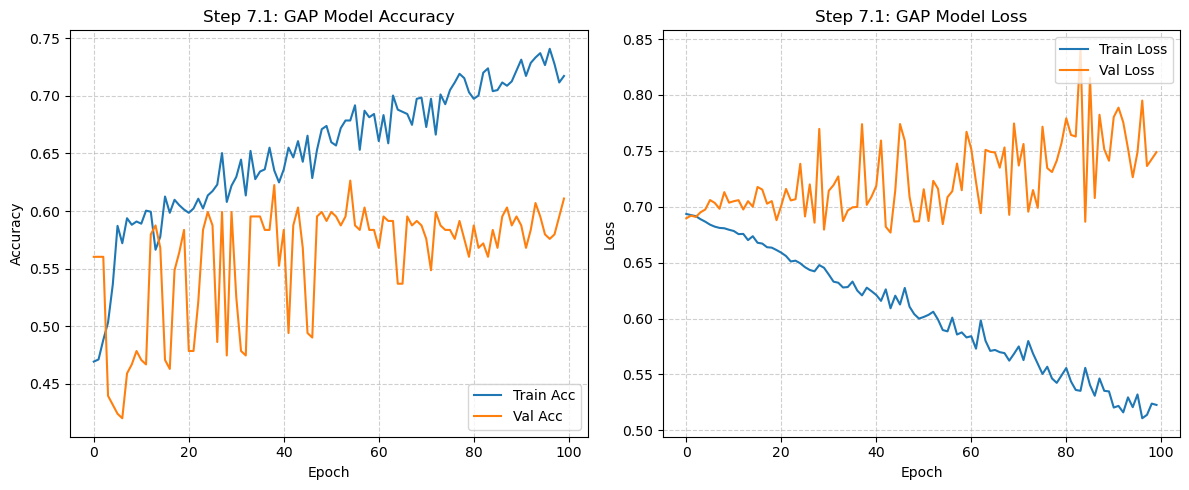


Step 7.1 GAP Evaluation: Statistical Power Check
------------------------------------------------------------
Metric               | Baseline   | Model (Val)
------------------------------------------------------------
Accuracy             | 0.5353     | 0.5837
AUC-ROC              | 0.5000     | 0.6618
Sensitivity          | 0.0000     | 0.7222
Specificity          | 1.0000     | 0.4071
------------------------------------------------------------

Detailed Classification Report:
              precision    recall  f1-score   support

      Benign       0.53      0.41      0.46       113
   Malignant       0.61      0.72      0.66       144

    accuracy                           0.58       257
   macro avg       0.57      0.56      0.56       257
weighted avg       0.58      0.58      0.57       257



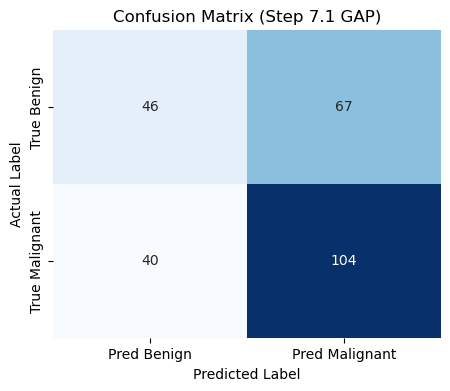

In [27]:
# Visualise the History
plot_training_history(history_step7, title_prefix="Step 7.1: GAP Model")

# Load Peak Validation Weights
model_step7_1.load_weights("step7_gap_model.keras")

# Evaluate and Automate the Summary
stats = eval_model_perf(
    model_step7_1,
    val_gen,
    step_name="Step 7.1 GAP",
    baseline_acc=majority_baseline_acc
)

best_epoch = history_step7.history['val_auc'].index(
    max(history_step7.history['val_auc'])
)

peak_train_acc = history_step7.history['accuracy'][best_epoch]

step7_summary = {
    "Step 7.1 GAP": {
        "Train Acc": peak_train_acc,
        "Val Acc": stats["Val Acc"],
        "Val AUC": stats["Val AUC"],
        "Sensitivity": stats["Sensitivity"],
        "Specificity": stats["Specificity"],
        "Gap": abs(peak_train_acc - stats["Val Acc"])
    }
}

Substituting Global Average Pooling for the Flatten-based classification head achieved a substantial parameter reduction from 14.5M to 1.57M (approximately a 9.3-fold decrease). The model no longer exhibited training accuracy approaching 100%, and validation loss stabilised across epochs, demonstrating successful mitigation of the overfitting problem observed in Step 6. Whilst validation accuracy remained relatively unchanged at approximately 0.58, validation AUC increased from 0.6037 to 0.6618, and sensitivity rose from 0.57 to 0.72, indicating enhanced malignant case detection. This suggests that constraining architectural capacity alone strengthens discriminative stability without necessitating additional regularisation mechanisms.

### 7.1.3 Save the Results

In [28]:
# Save everything
pd.DataFrame(step7_summary).T.to_csv('step7_gap_summary.csv')

# Save history
history_df = pd.DataFrame(history_step7.history)
history_df.to_csv('step7_history.csv', index=False)

# Save the Model (Architecture + Best Validation Weights)
model_step7_1.save("step7_gap_model_final.keras")

## 7.2 Regularisation Techniques
Whilst Global Average Pooling mitigated severe overfitting, the remaining generalisation gap and moderate validation accuracy suggest that architectural refinement alone is insufficient. Consequently, explicit regularisation methods are applied in the subsequent stage.
### 7.2.1 Dropout